## Data Processing

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import shap
import time
import matplotlib.pyplot as plt

In [3]:
def get_direction(playDescription):
        if("left" in playDescription):
                return 0
        if("right" in playDescription):
                return 2
        return 1

In [4]:
# load dataframes
games = pd.read_csv("data/games.csv")
plays = pd.read_csv("data/plays.csv")
tackles = pd.read_csv("data/tackles.csv")
players = pd.read_csv("data/players.csv")


In [5]:
# add target var (can also use play desc to count scrambles as runs)
plays["run"] = plays["passResult"].isna()

In [6]:
#makes column for if run(1 true, 0 false)
plays["run"] = plays["passResult"].isna()
#makes column for play direction
plays["direction"] = plays["playDescription"].apply(get_direction)
#filters play data
plays_filtered = plays[["gameId","quarter", "down", "yardsToGo", "possessionTeam","defensiveTeam","absoluteYardlineNumber", "gameClock", "preSnapHomeScore",
                        "preSnapVisitorScore", "offenseFormation", "defendersInTheBox","run","direction"]]

In [7]:
#filters game data
games_filtered = games[["gameId", "week","gameTimeEastern"]]

In [8]:
# filter players dataframe
players_filtered = players[["position", "nflId"]]

In [9]:
#combine game data with play data
data = plays_filtered.merge(games_filtered, on="gameId")

In [10]:
#make all game times purly numbers (probably not necessary - most models can handle datetime or can convert to int differently)
def str_to_time(time):
    splt = time.split(":")
    return int(splt[0]) * 60 + int(splt[1])
data["gameTimeEastern"] = data["gameTimeEastern"].apply(str_to_time)
data["gameClock"] = data["gameClock"].apply(str_to_time)
#drop game id
data.drop("gameId",axis =1, inplace=True)
#normalization]
for param in ['yardsToGo','absoluteYardlineNumber',	'gameClock', 'week','preSnapHomeScore',	'preSnapVisitorScore',	'defendersInTheBox','gameTimeEastern']:
    data[param] = (data[param] - data[param].mean())/data[param].std()
    



In [11]:
#find all unique teams
teams = data.possessionTeam.unique()
#1 hot encode teams and formations
data = pd.get_dummies(data, prefix=['possessionTeam', 'defensiveTeam', 'offenseFormation'])
#fill 1 nan in defeive players in the box
data.fillna(0,inplace=True)

In [12]:
#empty dictionary of team names
data_by_team_test = {x : pd.DataFrame() for x in teams}
data_by_team_train = {x : pd.DataFrame() for x in teams}
data_test = pd.DataFrame()
data_train = pd.DataFrame()
#fills dictionary with all plays according to possesion team
for team in teams:
    data_by_team_test[team] = data[data["possessionTeam_"+str(team)]]
    #seperate into train and test sets seperated by team 
    rows = len(data_by_team_test[team])
    rand_idx = np.random.randint(0, rows,size = int(rows/10))
    #make seperate train and test sets for each team
    data_by_team_train[team] = data_by_team_test[team].drop(data_by_team_test[team].index[rand_idx])
    data_by_team_test[team] = data_by_team_test[team].iloc[rand_idx]
    #create a joined train and test set(for overall)
    data_test = pd.concat([data_test, data_by_team_test[team]], ignore_index = True)
    data_train = pd.concat([data_train, data_by_team_train[team]], ignore_index = True)

#Randomize final sets to mix teams
data_test = data_test.sample(frac=1)
data_train = data_train.sample(frac=1)
#split datasets into parameters and result
data_test_run = data_test["run"]
#data_test_epa = data_test["expectedPoints"]
data_test_dir = data_test["direction"]
data_test.drop(["run","direction"],axis =1, inplace=True)

data_train_run = data_train["run"]
#data_train_epa = data_train["expectedPoints"]
data_train_dir = data_train["direction"]
data_train.drop(["run","direction"],axis =1, inplace=True)

data_test

,quarter,down,yardsToGo,absoluteYardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,defendersInTheBox,week,gameTimeEastern,...,defensiveTeam_TB,defensiveTeam_TEN,defensiveTeam_WAS,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
128,4,2,-1.392427,-0.770409,0.741022,0.299652,1.108805,-0.417929,-1.513527,-0.733174,...,False,False,False,True,False,False,False,False,False,False
825,2,1,0.389770,-1.481192,0.053105,1.041017,-0.313156,-0.417929,1.225526,-0.733174,...,False,False,False,False,False,False,True,False,False,False
133,4,1,0.389770,0.400293,-1.169444,1.570563,1.546331,-0.417929,0.442939,-0.733174,...,False,False,False,False,False,False,False,True,False,False
1030,3,1,0.389770,-0.310490,1.028901,0.511471,-0.313156,0.567556,-1.513527,-0.733174,...,False,False,False,False,False,False,False,True,False,False
1105,2,2,0.135171,-1.146706,1.357905,-1.183078,-0.750682,-0.417929,-0.730940,-0.733174,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,3,2,-0.628628,-1.313949,-1.027374,-0.547622,-0.313156,0.567556,1.225526,0.408454,...,False,False,False,False,False,False,False,False,True,False
229,3,2,0.389770,1.194698,1.668215,-0.123985,0.452515,0.567556,1.616819,-0.733174,...,False,False,False,False,False,False,False,True,False,False
82,4,2,0.389770,-1.063084,1.395292,1.041017,-0.313156,0.567556,0.051646,-0.733174,...,False,False,False,False,False,False,False,True,False,False
828,2,2,0.389770,0.442104,-1.573221,0.299652,-0.750682,-1.403415,-1.122234,0.408454,...,False,False,False,False,False,False,False,True,False,False


Covert all to NP arrays incase this makes Custum Regression Easier

In [13]:
data_test_run = np.ravel(np.array(data_test_run))
#data_test_epa = np.ravel(np.array(data_test_epa))
data_test_dir = np.ravel(np.array(data_test_dir))
data_test_param = np.array(data_test)

data_train_run = np.ravel(np.array(data_train_run))
#data_train_epa = np.ravel(np.array(data_train_epa))
data_train_dir = np.ravel(np.array(data_train_dir))
data_train_param = np.array(data_train)

Random Forest

In [14]:
# initial random forest classifier
clf = RandomForestClassifier(random_state=28)

In [15]:
clf.fit(data_train, data_train_run)

RandomForestClassifier(random_state=28)

In [16]:
preds = clf.predict(data_test)

In [17]:
acc = (preds == data_test_run).sum() / len(preds) * 100


## Hyperparameter Tuning

In [18]:
estimators = [50, 100, 200, 400]
depth = [None, 10, 20, 30]
param = ["gini", "entropy"]
res = []
for estimator in estimators:
    for d in depth:
        for p in param:
            clf = RandomForestClassifier(n_estimators=estimator, max_depth=d, criterion=p, random_state=28)
            clf.fit(data_train, data_train_run)
            preds = clf.predict(data_test)
            acc = (preds == data_test_run).sum() / len(preds)
            res.append({
              "n_estimators":estimator, "max_depth":d, "criterion":p, "accuracy":acc*100  
            })
results = pd.DataFrame(res)

In [19]:
# top 10 after tuning (difference is relatively negligible)
results.sort_values(by="accuracy",ascending=False).iloc[:10]

,n_estimators,max_depth,criterion,accuracy
29,400,20.0,entropy,75.263585
24,400,NaN,gini,75.263585
31,400,30.0,entropy,75.182482
15,100,30.0,entropy,75.182482
20,200,20.0,gini,75.182482
17,200,NaN,entropy,75.101379
16,200,NaN,gini,75.101379
4,50,20.0,gini,75.101379
23,200,30.0,entropy,75.020276
12,100,20.0,gini,74.939173


## Best Model Deep Dive

In [20]:
clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
clf.fit(data_train, data_train_run)
preds = clf.predict(data_test)
acc = (preds == data_test_run).sum() / len(preds) * 100
acc

74.45255474452554

<Axes: >

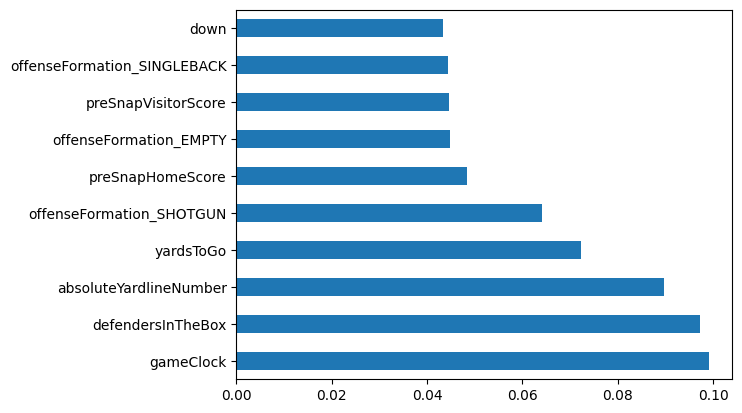

In [21]:
# plot top 10 feature importances
feat_importances = pd.Series(clf.feature_importances_, index=data_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [22]:
# work in progress still
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_test)
#shap.summary_plot(shap_values[1], data_test)

In [23]:
shap_values.shape
data_test.shape

(1233, 81)

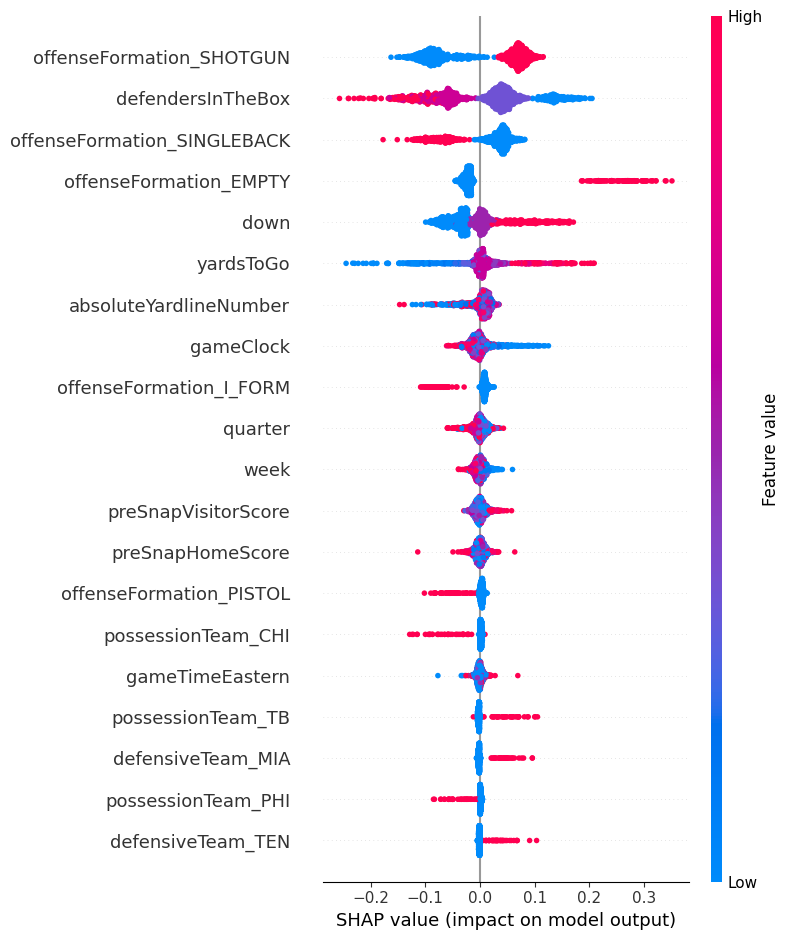

In [24]:
shap.summary_plot(shap_values[:,:,0], data_test)

## Team Specific Analysis

In [ ]:
# testing all teams on the same model
start = time.time()
clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
clf.fit(data_train, data_train_run)
accs1 = {}
for team in data_by_team_test.keys():
    actual = data_by_team_test[team]["run"]
    preds = clf.predict(data_by_team_test[team].drop(columns=["run", "direction"]))
    acc = (preds == actual).sum() / len(preds) * 100
    accs1[team] = acc
end = time.time()
print("time taken: " + str(end-start) + " seconds")
print("average accuracy (unweighted): " + str(sum(accs1.values()) / len(accs1.values())) + "%")

In [ ]:
# new model for each team
start = time.time()
accs = []
for team in data_by_team_test.keys():
    clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
    y_train = data_by_team_train[team]["run"]
    X_train = data_by_team_train[team].drop(columns=["run", "direction"])
    clf.fit(X_train, y_train)
    actual = data_by_team_test[team]["run"]
    preds = clf.predict(data_by_team_test[team].drop(columns=["run", "direction"]))
    acc = (preds == actual).sum() / len(preds) * 100
    accs.append(acc)
end = time.time()
print("time taken: " + str(end-start) + " seconds")
print("average accuracy (unweighted): " + str(sum(accs) / len(accs)) + "%")

In [ ]:
# look at best teams
teams_acc = sorted(accs1.items(), key=lambda x: x[1], reverse=True)
teams = [team for team, accuracy in teams_acc]
accuracies = [accuracy for team, accuracy in teams_acc]
plt.figure(figsize=(8, 5)) 
plt.barh(teams, accuracies, edgecolor='black')

Linear Regression

In [ ]:
model = LinearRegression()
model.fit(data_train_param, data_train_run)
pass_pred = model.predict(data_test_param)
pass_pred = np.where(pass_pred>.5,1,0)
matching = np.sum(pass_pred == data_test_run)
#percentage accuarcy
matching/len(pass_pred) * 100